# Deconvolution and occlusion analysis

In this part, we look at two methods that are a bit old but often pop up in tutorials on deep learning or in papers.

In summary, we could say that these aim to provide explanation for a *given input image*. We will shortly see that these methods are rather for illustration purposes than rigorous explanition.

**DISCLAIMER:** the notebook reflects the understanding of the author, so watch out for mistakes

## CNN implementation & training

In this tutorial, we will work with a simple CNN trained on two classes of MNIST.

Below, we only implement the standard pipeline. In lack of time, one can skip most of this, since we'll only need the trained model for further investigations.

In [1]:
import torch 
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=lambda x: np.array(x))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=lambda x: np.array(x))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:

from torch.utils.data import DataLoader, Subset

In [5]:
def retrieve_indices(classes,dataset):
  class_indices=[i for i,label in enumerate(dataset.targets) if int(label) in classes] # label itself was a tensor :/
  return class_indices

In [6]:

classes=[1,8]

In [7]:
trainset=Subset(mnist_trainset,retrieve_indices(classes,mnist_trainset))

In [8]:
testset=Subset(mnist_testset,retrieve_indices(classes,mnist_testset))

In [9]:
train_dataloader=DataLoader(trainset,batch_size=50,shuffle=True)

In [10]:
test_dataloader=DataLoader(testset,batch_size=50,shuffle=True)

In [11]:
class mnist_cnn(nn.Module):

  def __init__(self,batch_transform,loss):
    super(mnist_cnn,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=4,stride=2)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=2)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=10,kernel_size=2,stride=2)
    self.dense=nn.Linear(in_features=90,out_features=1)
    self.batch_transform=batch_transform
    self.loss=loss

  def forward(self,x):

    x=self.batch_transform(x) # eg. rescale
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=torch.flatten(x,start_dim=1)
    x=torch.sigmoid(self.dense(x))

    return x 

In [12]:
def binarize_labels(labels,classes): # classes[0] becomes ~0, classes[1] ~1
 
  return ((labels-classes[0])/(classes[1]-classes[0])).to(torch.float32)

In [13]:
def trainstep(model,optimizer,batch):

  labels=binarize_labels(batch[1],classes)

  optimizer.zero_grad()
  logits=model(batch[0])[:,0]

  loss=model.loss(logits,labels)

  loss.backward()
  optimizer.step()

  return loss.detach()



In [14]:
model=mnist_cnn(batch_transform=lambda x: (x/255.).reshape(-1,1,28,28), loss=nn.BCELoss()) # standard choice to rescale image

In [15]:
def accuracy(model,batch):

  n=batch[0].shape[0]

  probabilities=model(batch[0])[:,0]

  correct=0

  for i in range(n):
    if probabilities[i]>0.5 and batch[1][i]>4:
      correct+=1
    elif probabilities[i]<0.5 and batch[1][i]<4:
      correct+=1
  return correct/n


In [16]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [17]:
for i in range(10):
  full_loss=0
  full_accuracy=0
  for j,batch in enumerate(train_dataloader):
    loss=trainstep(model,optimizer,batch)
    full_loss=full_loss*j/(j+1)+loss.detach()/(j+1) # compute average in a 'sliding' manner, maybe familiar from RL
    full_accuracy=full_accuracy*j/(j+1)+accuracy(model,batch)/(j+1)
  print('epoch completed')
  print(full_loss)
  print(full_accuracy)
  
  

epoch completed
tensor(0.6486)
0.7113510520487266
epoch completed
tensor(0.3254)
0.9431746031746026
epoch completed
tensor(0.1382)
0.9608213362864519
epoch completed
tensor(0.0942)
0.9710188261351049
epoch completed
tensor(0.0741)
0.9765873015873011
epoch completed
tensor(0.0626)
0.9794315245478028
epoch completed
tensor(0.0548)
0.9815743816906601
epoch completed
tensor(0.0500)
0.9825396825396823
epoch completed
tensor(0.0460)
0.9839553340716127
epoch completed
tensor(0.0429)
0.9852380952380951


## Occlusion analysis

The idea is to mask out a part of the image and see how class probabilities vary. Idea is taken from https://arxiv.org/abs/1311.2901v2 by Zeiler and Fergus

In [18]:
import matplotlib.pyplot as plt


In [23]:
def mask_to_background(image,mask_size,top_left_anchor):

  # background of characters is 0

  x_a,y_a=top_left_anchor # expected as a tuple of 2

  if x_a+mask_size<=image.shape[0] and y_a+mask_size<=image.shape[1]:

    mask=torch.ones(image.shape,dtype=torch.float32)
    mask[x_a:x_a+mask_size,y_a:y_a+mask_size].multiply_(0)

    return image*mask
  else:
    print('invalid parameter combination')


Let us consider dividing the picture into a 7-by-7 grid (mask size 4) and occluding one square one time.

In [115]:
image=next(iter(test_dataloader))[0][0]

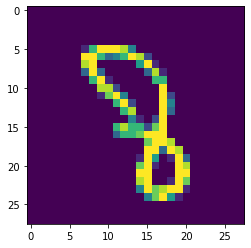

In [116]:
plt.imshow(image)

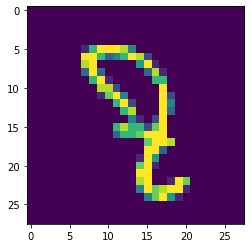

In [118]:
plt.imshow(mask_to_background(image,mask_size=4,top_left_anchor=(18,18)))

In [119]:
occlusion_map=torch.zeros(image.shape,dtype=torch.float32) # store results here

In [120]:
m=4

for x_a in range(7):
  for y_a in range(7):
    masked_image=mask_to_background(image,mask_size=m,top_left_anchor=(x_a*m,y_a*m))
    prob=model(masked_image.reshape(1,28,28))
    occlusion_map[x_a*m:x_a*m+m,y_a*m:y_a*m+m]=prob # store results that spatially correspond to original image

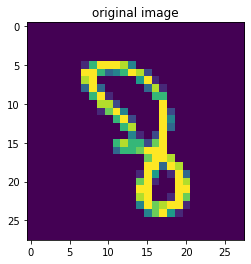

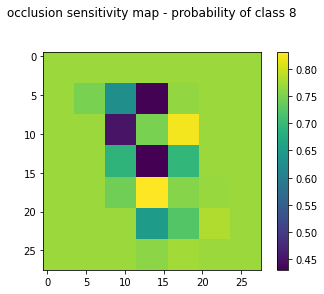

In [121]:
plt.figure()
plt.imshow(image)
plt.title('original image')
plt.show()

plt.figure()
plt.imshow(occlusion_map.detach().numpy())
plt.title('occlusion sensitivity map - probability of class 8\n\n')
plt.colorbar()
plt.show()

## Deconvolutions



 ### intro
 
 We'll more or less follow: https://arxiv.org/abs/1311.2901v2 by Zeiler and Fergus whose paper promises to *'reveals the input stimuli that excite individual feature maps at any layer in the model'*. For some impressive figures, one shall refer to the paper but in summary, we can say that the real meaning of the outputs of the explanatory model is more or less unclear. It is also a question however, if it is meaningful to analyze single neuronal activations.

The purpose of this part in the tutorial is to give an insight into what is behind the omnipresent 'let us visualize what triggers single neurons' figures in intros to deep learning. Thus, the interested reader is advised to read through the rather lengthly theory part of the text too.

If you are skeptical about all of this (well, maybe you should be...) then just skim through the rest without taking it too seriously. 

Either way, I highly recommend to look into paper [Towards falsifiable interpretability research](https://arxiv.org/abs/1311.2901v2) for a more recent, critical view on interpretability methods for DNNs with interesting takeaways for methods like this.

### the method

The method is best summarized in the words of the authors:

*'To examine a convnet, a deconvnet is attached to each
of its layers, as illustrated in Fig. 1(top), providing a
continuous path back to image pixels. To start, an
input image is presented to the convnet and features
computed throughout the layers. To examine a given
convnet activation, we set all other activations in the
layer to zero and pass the feature maps as input to
the attached deconvnet layer. Then we successively
(i) unpool, (ii) rectify and (iii) filter to reconstruct
the activity in the layer beneath that gave rise to the
chosen activation. This is then repeated until input
pixel space is reached.'*


*'Unpooling: In the convnet, the max pooling operation is non-invertible, however we can obtain an approximate inverse by...'* (we won't need this in the tutorial)

*'Rectification: The convnet uses relu non-linearities,
which rectify the feature maps thus ensuring the feature maps are always positive. To obtain valid feature reconstructions at each layer (which also should
be positive), we pass the reconstructed signal through
a relu non-linearity.'*

*'Filtering: The convnet uses learned filters to con-
volve the feature maps from the previous layer. To
invert this, the deconvnet uses transposed versions of
the same filters, but applied to the rectified maps, not
the output of the layer beneath. In practice this means
flipping each filter vertically and horizontally.'*



### OK but what does this mean?

Before jumping into code, let's familiarize ourselves with the way deconvolutional networks work. This seemingly simple goal is not so straightforward to achieve, since the original paper we follow and the Pytorch documentation do not seem to refer to the same thing.

In the **paper**, it is said that '*we successively
(i) unpool, (ii) rectify and (iii) filter to reconstruct
the activity in the layer beneath that gave rise to the
chosen activation...*' In other words, the process of deconvolution is seen as some kind of inversion.

We hope to achieve 'filtering' with the transposed convolution layer of **Pytorch**, where the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) reads as: *'This module can be seen as the gradient of Conv2d with respect to its input. It is also known as a fractionally-strided convolution or a deconvolution (although it is not an actual deconvolution operation)'*

Nice. 

To make sense of all of this, we refer to yet another resource that approaches from theory-side: https://link.springer.com/chapter/10.1007/978-3-319-46466-4_8 

Based on that, we can say the following:

Suppose that we have a (scalar) feature p that is dependent on the output of a convolutional layer and we know the gradient of p with respect to the output.

 First we aim to compute the gradient of p with respect to the *input* of the layer. Conceptually, it is very simple, since the convolution operation is basically $\mathbf{y}=A \mathbf{x}+\mathbf{b}$ where matrix A does the convolution (with a nontrivial structure) and both **x** input and **y** output are represented as vectors. 

 The desired output is: $ (\frac{\partial p}{\partial \mathbf{x}})_i = \frac{\partial p}{\partial x_i}= \sum_j \frac{\partial p}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_j   \frac{\partial p}{\partial y_j} A_{ji} = ( A^T  \frac{\partial p}{\partial \mathbf{y}})_i$

 Now we can see that the paper and docs are basically the same for 'filtering' but it is unclear in what sense this operation will contribute to *' reconstruct the activity in the layer beneath that gave rise to the chosen activation'* 

Moreover, the use of ReLU needs to be thought over. The paper proposes that ReLU is applied before passing features through the transposed convlayers. The reader is reminded that this choice is (i) not straightforward (ii) not the only choice. Different ways to 'reverse' ReLU and it leads to significatly different outcomes according to the cited Springer chapter. Also, this particular choice makes the interpretation of the outputs of a deconvolutional net hardly interpretable, since this is *not* the gradient of p wrt. the input pixels. (Note that other choices with ReLU lead to a well defined meaning of the output, see SaliNets for network saliency.)

In practice, we mask out all but one activation in a custom layer and then pass through deconvolutions. It is not hard to realize that in this case, p is the (chosen activation) times (the output of the chosen neuron). It also makes clear that there is not much point in passing a whole activation block through the deconv architecture.

 



Now then let's get down to coding finally:

In [28]:
image=next(iter(train_dataloader))[0][0]

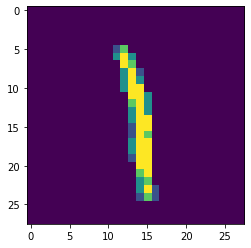

In [29]:
plt.imshow(image)

In [30]:
# compute activation maps
activations=[]
x=image.reshape(1,28,28)
x=model.batch_transform(x)
for layer in [model.conv1,model.conv2,model.conv3]:
  x=F.relu(layer(x))
  activations.append(x)

In [31]:
def mask(x,y,d,size): # make a mask for picking a given neuronal activation 
  mask=torch.zeros(size,dtype=torch.float32)
  mask[:,d,x,y]=1.

  return mask

One could go in a less pedestrian way for the deconvnet, but since our net is lightweight, there is no point in it. We will re-use the weights from the trained convlayers as suggested in the paper. The only question is if we need to flip the kernels. Let's try first without that!

In [32]:
# we'll use the hyperparameters from the original net
# set bias to zero: it is not meaningful to use them when doing deconvolution

deconv1=nn.ConvTranspose2d(in_channels=10,out_channels=1,kernel_size=4,stride=2)
deconv1.weight=nn.Parameter(model.conv1.weight)
deconv1.bias=None

deconv2=nn.ConvTranspose2d(in_channels=20,out_channels=10,kernel_size=3,stride=2)
deconv2.weight=nn.Parameter(model.conv2.weight)
deconv2.bias=None

deconv3=nn.ConvTranspose2d(in_channels=10,out_channels=20,kernel_size=2,stride=2)
deconv3.weight=nn.Parameter(model.conv3.weight)
deconv3.bias=None


In [33]:
def deconv_from_layer_list(input,layers): # implementing the method from the paper
  x=input
  for layer in layers:
    x=layer(F.relu(x))
  return x

In [34]:
activation=activations[0]*mask(1,1,1,activations[0].shape) # pick one from the first activation block's second kernel at position 1,1

In [35]:
out=deconv_from_layer_list(activation,[deconv1]) # deconvolve - what do you expect go get?

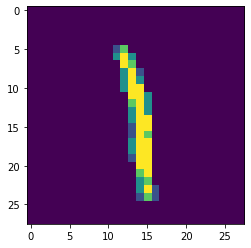

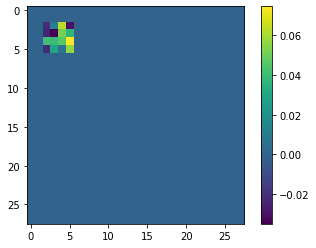

In [37]:
out_=out.detach().numpy()

plt.figure()
plt.imshow(image[:,:])
plt.figure()
plt.imshow(out_[0,0,:,:])
plt.colorbar()

Yup, it looks like a convolutional kernel! When thinking about it, it is obvious that this is what we shall get. Now the proof is in the pudding: 

In [38]:
activation[0,1,1,1] # we picked this feature and set everything else to 0

tensor(0.2208, grad_fn=<SelectBackward>)

In [39]:
out_[0,0,2:6,2:6] # the colorful (nonzero) area above

array([[-0.0213485 ,  0.01172877,  0.06317053, -0.02939272],
       [-0.02395218, -0.03492154,  0.05169481,  0.03717804],
       [ 0.04151992,  0.03870743,  0.04570105,  0.07462555],
       [-0.02181742,  0.02903338,  0.00723445,  0.05708337]],
      dtype=float32)

In [40]:
model.conv1.weight[1,0,:,:] # weight from model corresponding to the same filter we want to deconvolve

tensor([[-0.0967,  0.0531,  0.2862, -0.1331],
        [-0.1085, -0.1582,  0.2342,  0.1684],
        [ 0.1881,  0.1753,  0.2070,  0.3380],
        [-0.0988,  0.1315,  0.0328,  0.2586]], grad_fn=<SliceBackward>)

One can check that we got back our (conv kernel) times (activation) as expected so it was right not to flip weights when initializing transposed convlayers.

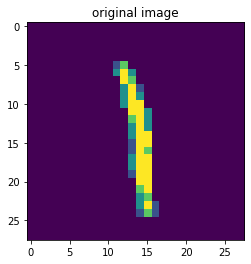

In [41]:
plt.figure()
plt.title('original image')
plt.imshow(image)

In [44]:
# for a more interesting example

outputs=[]

for kernel in range(10):
  for x_ in range(3):
    for y_ in range(3):
      text='reconstruction from kernel %d, x: %d, y: %d'%(kernel,x_,y_)

      activation=activations[2]*mask(x_,y_,kernel,activations[2].shape)
      out=deconv_from_layer_list(activation,[deconv3,deconv2,deconv1]) # behold the order of deconv layers

      out_=out.detach().numpy()
      fig=(out_[0,0,:,:])

      outputs.append((float(activation[0,kernel,x_,y_].detach()),text,fig))

     


In [47]:
sorted_outputs=sorted(outputs,key=lambda x: -x[0])  # descending by activation

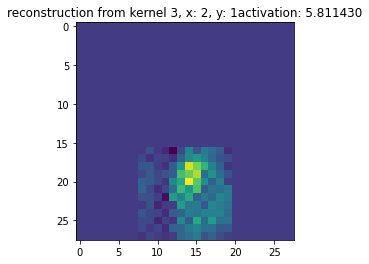

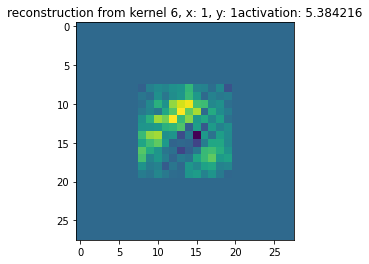

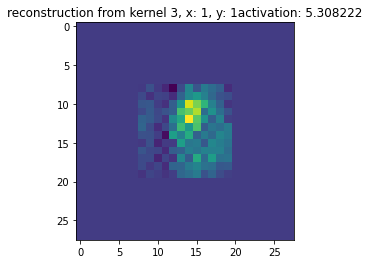

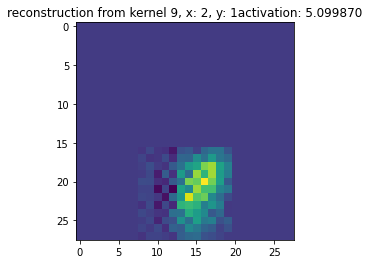

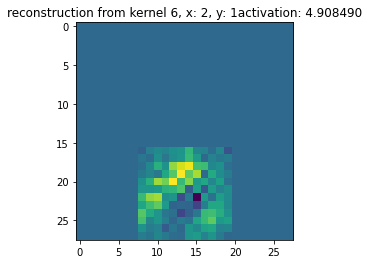

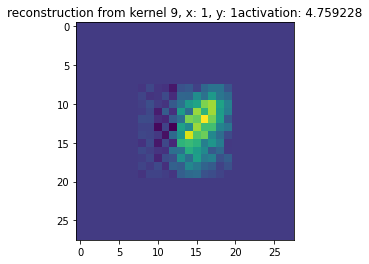

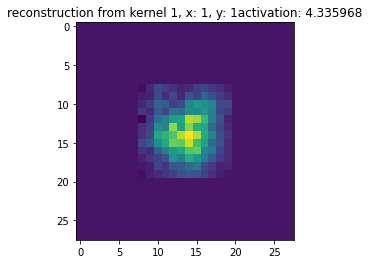

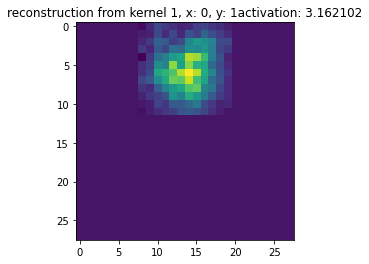

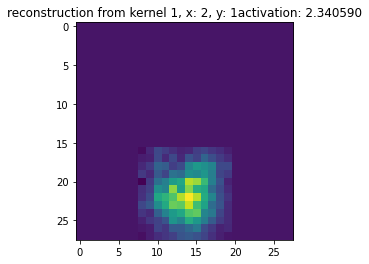

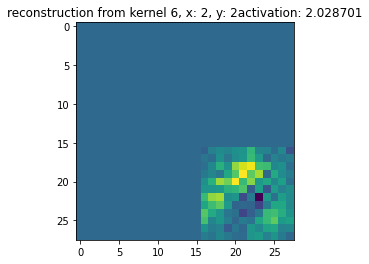

In [48]:
for i in range(10): # top 10 outputs
  plt.figure()
  plt.title(sorted_outputs[i][1]+ 'activation: %f'%(sorted_outputs[i][0]))
  plt.imshow(sorted_outputs[i][2])
  plt.show()

Well, it is not very informative. Let's see for an 8!

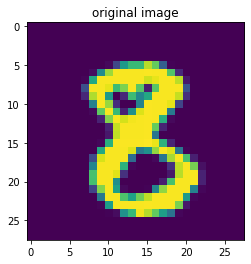

In [72]:
image=next(iter(train_dataloader))[0][0]
plt.figure()
plt.title('original image')
plt.imshow(image)

In [73]:
# compute activation maps
activations=[]
x=image.reshape(1,28,28)
x=model.batch_transform(x)
for layer in [model.conv1,model.conv2,model.conv3]:
  x=F.relu(layer(x))
  activations.append(x)

In [74]:
# for a more interesting example

outputs=[]

for kernel in range(10):
  for x_ in range(3):
    for y_ in range(3):
      text='reconstruction from kernel %d, x: %d, y: %d'%(kernel,x_,y_)

      activation=activations[2]*mask(x_,y_,kernel,activations[2].shape)
      out=deconv_from_layer_list(activation,[deconv3,deconv2,deconv1]) # behold the order of deconv layers

      out_=out.detach().numpy()
      fig=(out_[0,0,:,:])

      outputs.append((float(activation[0,kernel,x_,y_].detach()),text,fig))

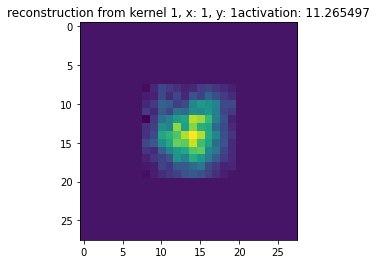

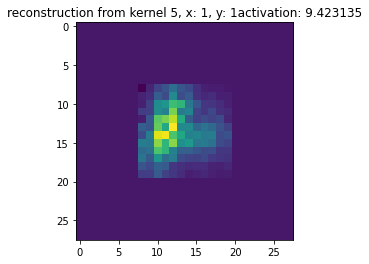

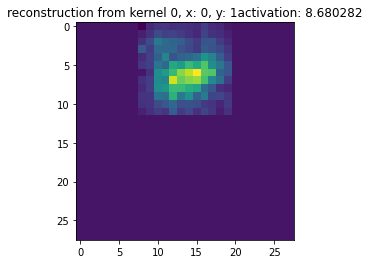

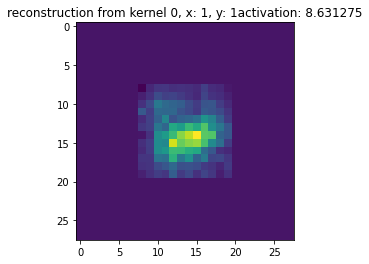

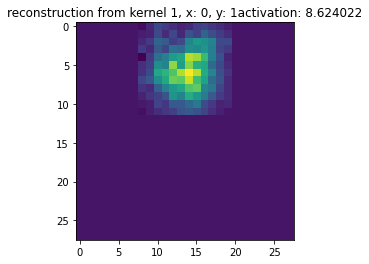

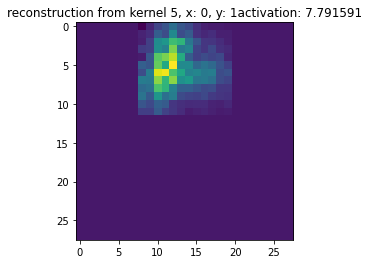

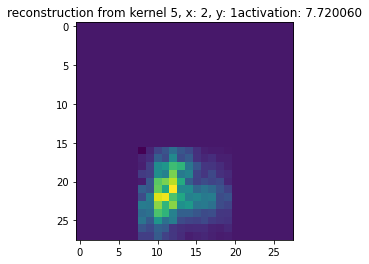

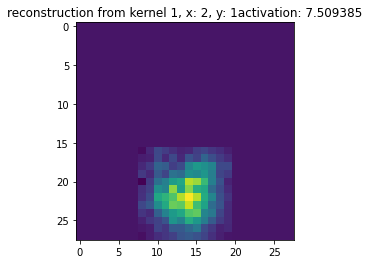

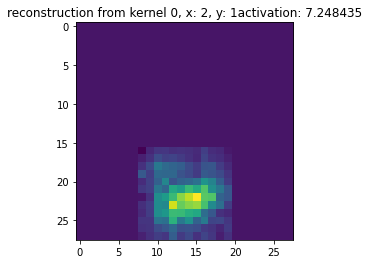

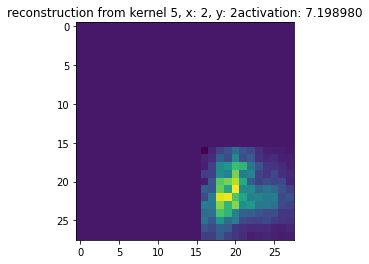

In [75]:
sorted_outputs=sorted(outputs,key=lambda x: -x[0])  # descending by activation
for i in range(10): # top 10 outputs
  plt.figure()
  plt.title(sorted_outputs[i][1]+ 'activation: %f'%(sorted_outputs[i][0]))
  plt.imshow(sorted_outputs[i][2])
  plt.show()

Well, let's say that we can observe some horizontal lines that may be absent for 1s but present for 8s. Anyway, this demo is not very convincing but this is what we could to with such a simple architecture.

For fancy images, refer to the sources linked.